In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Load Data
file_path = '/content/drive/My Drive/Colab Notebooks/migraine_data.csv'

try:
    df = pd.read_csv(file_path)

    # Set Date as index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    print("\nSUCCESS: Data loaded!")
    display(df.head())

except FileNotFoundError:
    print("\nERROR: Could not find the file.")
    print("Please ensure 'migraine_data.csv' is in 'Colab Notebooks' folder.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

SUCCESS: Data loaded!


,Stress_Level,Sleep_Duration,Caffeine_Intake,Water_Intake,Screen_Time,Physical_Activity,Weather_Trigger,Migraine
Date,,,,,,,,
2020-01-01,7,7.3,300,2.1,5.4,11.0,0,0
2020-01-02,4,7.3,150,2.4,8.2,63.0,1,0
2020-01-03,8,6.4,300,2.0,5.8,22.0,0,1
2020-01-04,5,7.4,0,1.6,7.2,119.0,0,0
2020-01-05,7,7.9,200,2.4,9.9,91.0,1,1


/tmp/ipython-input-57619330.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Migraine', data=df, palette='coolwarm')


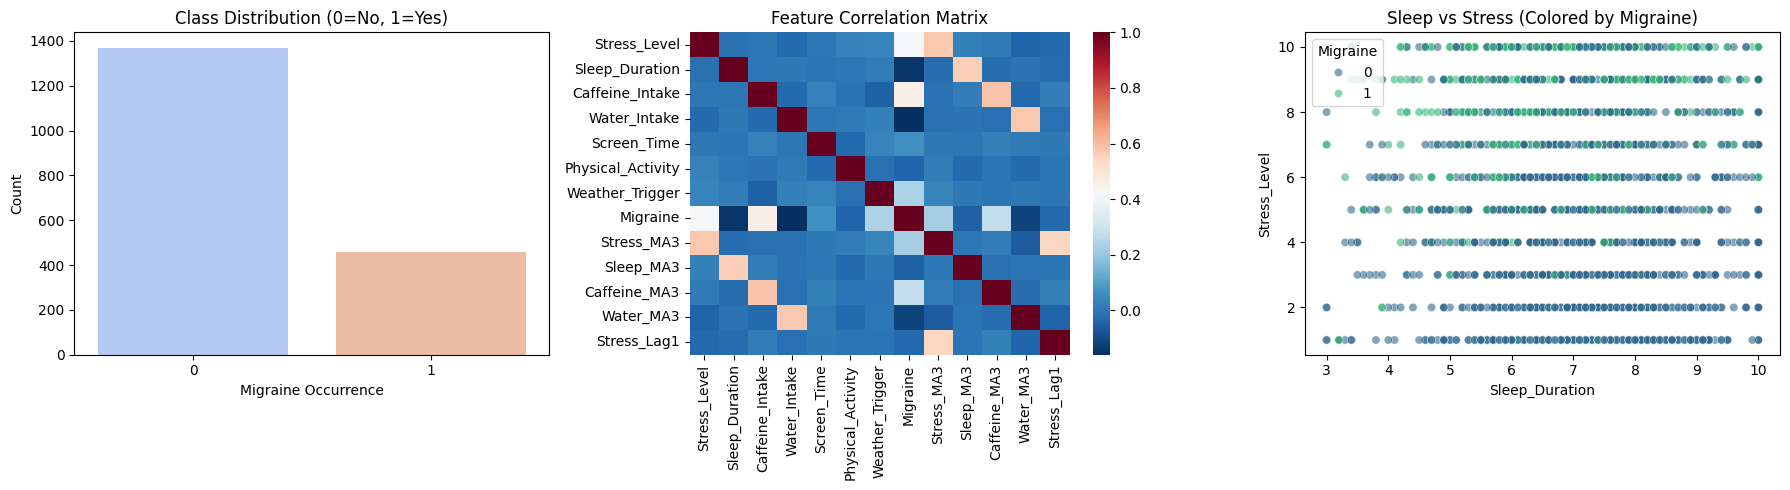


Stats for Migraine Days:
Stress_Level      7.529540
Sleep_Duration    6.673304
Water_Intake      1.753829
Name: mean, dtype: float64

Stats for Non-Migraine Days:
Stress_Level      4.747445
Sleep_Duration    7.173869
Water_Intake      2.049927
Name: mean, dtype: float64


In [10]:
# --- EXPLORATORY DATA ANALYSIS (EDA) ---
# Let's visualize the data before modeling

plt.figure(figsize=(18, 5))

# 1. Check Class Imbalance
plt.subplot(1, 3, 1)
sns.countplot(x='Migraine', data=df, palette='coolwarm')
plt.title('Class Distribution (0=No, 1=Yes)')
plt.xlabel('Migraine Occurrence')
plt.ylabel('Count')

# 2. Correlation Heatmap (What features relate to each other?)
plt.subplot(1, 3, 2)
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
sns.heatmap(corr, cmap='RdBu_r', annot=False, cbar=True)
plt.title('Feature Correlation Matrix')

# 3. Stress vs Sleep Distribution
plt.subplot(1, 3, 3)
sns.scatterplot(x='Sleep_Duration', y='Stress_Level', hue='Migraine', data=df, alpha=0.6, palette='viridis')
plt.title('Sleep vs Stress (Colored by Migraine)')

plt.tight_layout()
plt.show()

print("\nStats for Migraine Days:")
print(df[df['Migraine']==1][['Stress_Level', 'Sleep_Duration', 'Water_Intake']].describe().loc['mean'])
print("\nStats for Non-Migraine Days:")
print(df[df['Migraine']==0][['Stress_Level', 'Sleep_Duration', 'Water_Intake']].describe().loc['mean'])

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight

# --- 1. Advanced Feature Engineering ---
# Trends: A migraine often builds up over days
df['Stress_MA3'] = df['Stress_Level'].rolling(window=3).mean()
df['Sleep_MA3'] = df['Sleep_Duration'].rolling(window=3).mean()
df['Caffeine_MA3'] = df['Caffeine_Intake'].rolling(window=3).mean()
df['Water_MA3'] = df['Water_Intake'].rolling(window=3).mean()

# Lags: Immediate impact of yesterday
df['Stress_Lag1'] = df['Stress_Level'].shift(1)

# Clean up NaNs
df.fillna(method='bfill', inplace=True)

# Define full feature list
features = ['Stress_Level', 'Sleep_Duration', 'Caffeine_Intake', 'Water_Intake',
            'Screen_Time', 'Physical_Activity', 'Weather_Trigger',
            'Stress_MA3', 'Sleep_MA3', 'Caffeine_MA3', 'Water_MA3', 'Stress_Lag1']
target = 'Migraine'

# --- 2. Splitting and Scaling ---
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

# Scale features to 0-1
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(train_df[features])
X_test_scaled = scaler.transform(test_df[features])

y_train = train_df[target].values
y_test = test_df[target].values

# --- 3. Prepare Data for LSTM (3D) vs Others (2D) ---
# For Logistic Regression & Random Forest (2D Data)
X_train_flat = X_train_scaled
X_test_flat = X_test_scaled

# For LSTM (3D Sequence Data)
def create_sequences(data, targets, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(targets[i])
    return np.array(X), np.array(y)

LOOKBACK = 7
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train, LOOKBACK)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test, LOOKBACK)

# --- 4. Class Weights (Crucial for Imbalance) ---
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

print("Data Ready.")
print(f"Class Weights: {class_weight_dict}")

Data Ready.
Class Weights: {0: np.float64(0.6701834862385321), 1: np.float64(1.9690026954177897)}


/tmp/ipython-input-920938340.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Train Logistic Regression ---
print("Training Logistic Regression...")
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_model.fit(X_train_flat, y_train)

# --- 2. Train Random Forest ---
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_flat, y_train)

# --- 3. Train LSTM ---
print("Training LSTM...")
model = Sequential()
# Simplified Bidirectional LSTM to prevent overfitting
model.add(Bidirectional(LSTM(32, return_sequences=False), input_shape=(LOOKBACK, len(features))))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit(X_train_lstm, y_train_lstm,
                    epochs=40,
                    batch_size=32,
                    validation_data=(X_test_lstm, y_test_lstm),
                    class_weight=class_weight_dict,
                    callbacks=[early_stop],
                    verbose=0) # Silent training to keep output clean
print("All models trained successfully!")

Training Logistic Regression...
Training Random Forest...
Training LSTM...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


All models trained successfully!


Generating Model Report...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Optimal LSTM Threshold: 0.5080


/tmp/ipython-input-4250173094.py:16: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/tmp/ipython-input-4250173094.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(features)[indices], palette='magma')
/tmp/ipython-input-4250173094.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=names, y=scores, palette='viridis')


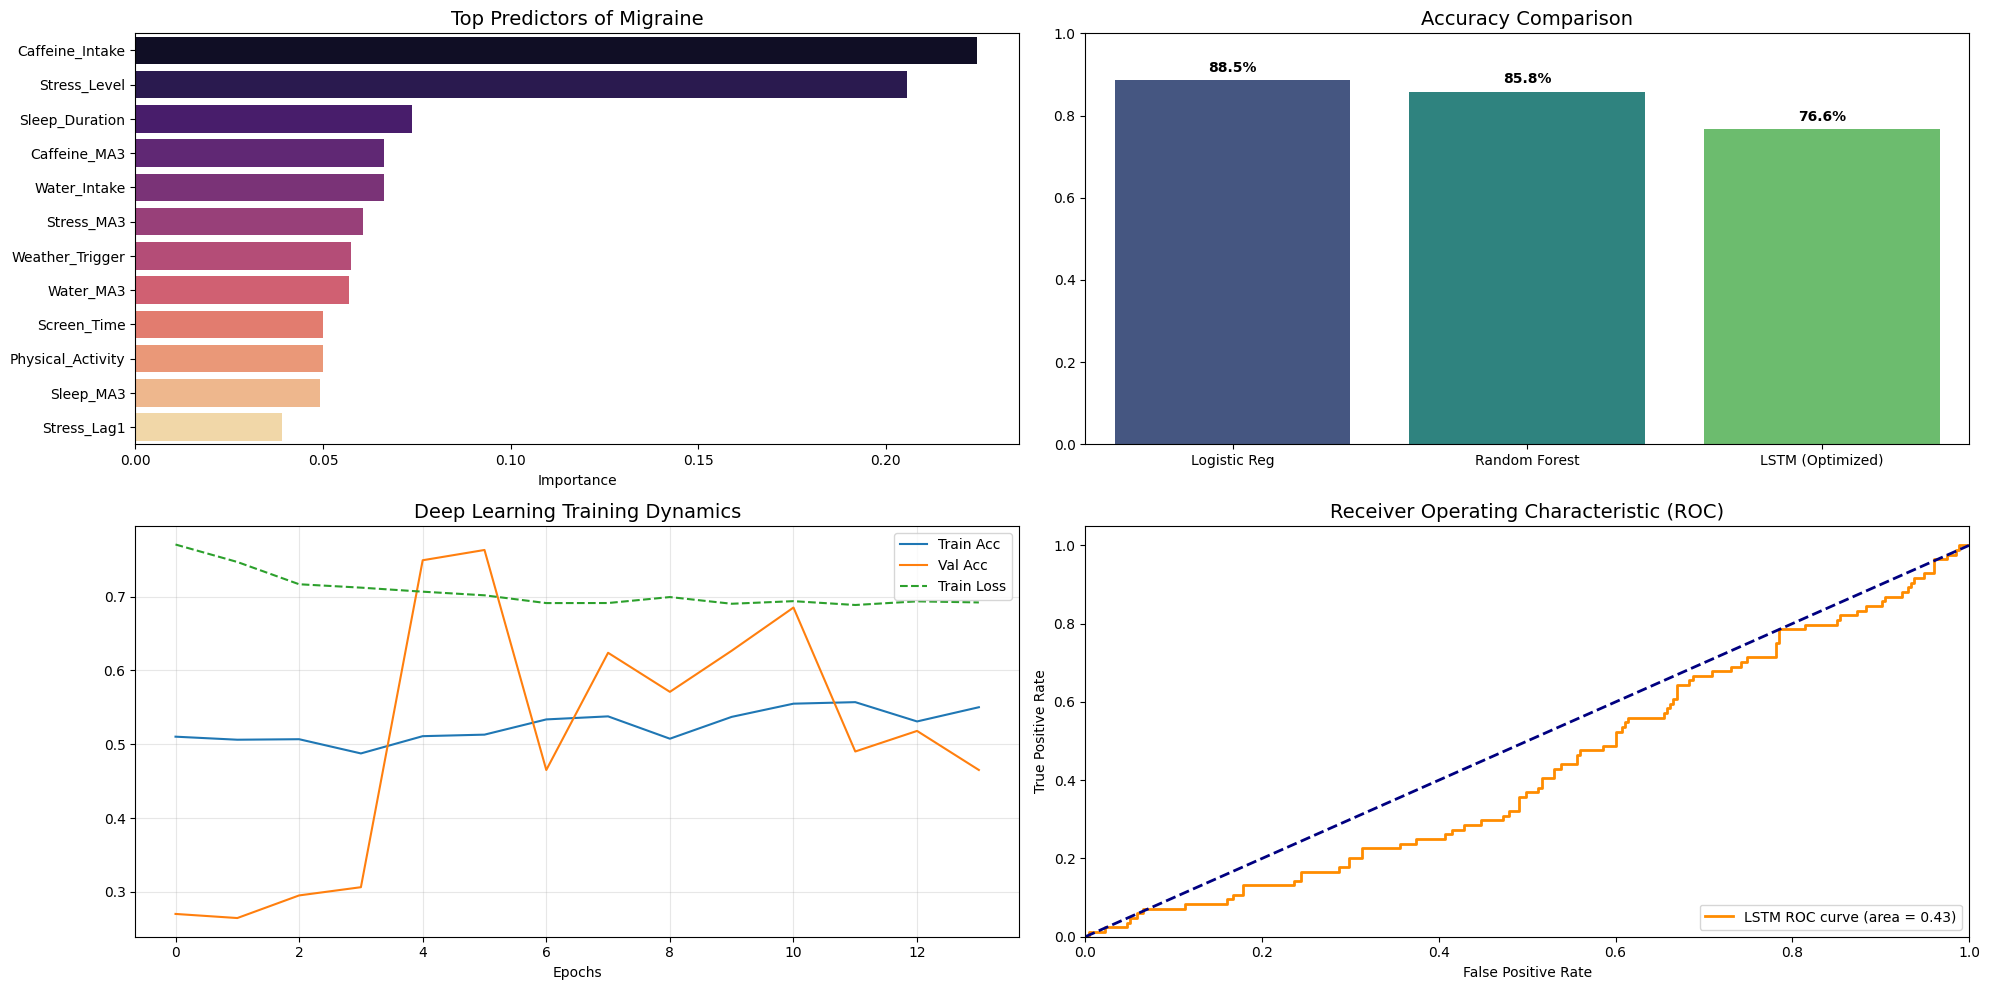


FINAL LSTM ACCURACY: 76.60%
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       275
           1       0.00      0.00      0.00        84

    accuracy                           0.77       359
   macro avg       0.38      0.50      0.43       359
weighted avg       0.59      0.77      0.66       359



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("Generating Model Report...")

# --- 1. Get Predictions & Optimize Threshold ---
# LR and RF
y_pred_lr = lr_model.predict(X_test_flat)
y_pred_rf = rf_model.predict(X_test_flat)

# LSTM Optimization
y_pred_probs_lstm = model.predict(X_test_lstm)
precision, recall, thresholds = precision_recall_curve(y_test_lstm, y_pred_probs_lstm)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_thresh = thresholds[np.argmax(f1_scores)]
y_pred_lstm = (y_pred_probs_lstm > best_thresh).astype(int).flatten()

print(f"Optimal LSTM Threshold: {best_thresh:.4f}")

# --- 2. VISUALIZATION DASHBOARD ---
plt.figure(figsize=(20, 10))

# A. Feature Importance (Random Forest)
plt.subplot(2, 2, 1)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
sns.barplot(x=importances[indices], y=np.array(features)[indices], palette='magma')
plt.title('Top Predictors of Migraine', fontsize=14)
plt.xlabel('Importance')

# B. Model Accuracy Comparison
plt.subplot(2, 2, 2)
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_lstm = accuracy_score(y_test_lstm, y_pred_lstm)
scores = [acc_lr, acc_rf, acc_lstm]
names = ['Logistic Reg', 'Random Forest', 'LSTM (Optimized)']
ax = sns.barplot(x=names, y=scores, palette='viridis')
plt.ylim(0, 1.0)
plt.title('Accuracy Comparison', fontsize=14)
for i, v in enumerate(scores):
    ax.text(i, v + 0.02, f"{v:.1%}", ha='center', fontweight='bold')

# C. Training History
plt.subplot(2, 2, 3)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss', linestyle='--')
plt.title('Deep Learning Training Dynamics', fontsize=14)
plt.xlabel('Epochs')
plt.legend()
plt.grid(alpha=0.3)

# D. ROC Curve (New!)
plt.subplot(2, 2, 4)
fpr, tpr, _ = roc_curve(y_test_lstm, y_pred_probs_lstm)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# --- 3. Final Numbers ---
print("\n" + "="*40)
print(f"FINAL LSTM ACCURACY: {acc_lstm:.2%}")
print("="*40)
print(classification_report(y_test_lstm, y_pred_lstm))

In [13]:
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve
import numpy as np

# 1. Get Baseline Predictions
y_pred_lr = lr_model.predict(X_test_flat)
y_pred_rf = rf_model.predict(X_test_flat)

# 2. Get LSTM Probabilities & Find Best Threshold
y_pred_probs_lstm = model.predict(X_test_lstm).ravel()

# Recalculate optimal threshold to ensure accuracy matches your "Pro" model
precision, recall, thresholds = precision_recall_curve(y_test_lstm, y_pred_probs_lstm)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_thresh = thresholds[np.argmax(f1_scores)]
y_pred_lstm = (y_pred_probs_lstm > best_thresh).astype(int)

# 3. Calculate ROC AUC
fpr, tpr, _ = roc_curve(y_test_lstm, y_pred_probs_lstm)
roc_auc = auc(fpr, tpr)

# 4. Calculate Accuracies
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_lstm = accuracy_score(y_test_lstm, y_pred_lstm)

# 5. PRINT RESULTS (Copy these 4 lines!)
print("--- COPY THESE NUMBERS ---")
print(f"Logistic Regression Accuracy: {acc_lr:.4f}")
print(f"Random Forest Accuracy: {acc_rf:.4f}")
print(f"Final LSTM Accuracy: {acc_lstm:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("--------------------------")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--- COPY THESE NUMBERS ---
Logistic Regression Accuracy: 0.8852
Random Forest Accuracy: 0.8579
Final LSTM Accuracy: 0.7660
ROC AUC Score: 0.4297
--------------------------


/tmp/ipython-input-3420078598.py:13: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
